In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from scipy import stats

%matplotlib notebook

In [2]:
def create_gaussian_J(N, p=1, gb=0, g=1):
    
    '''
    returns a random Gaussian weighted connectivity matrix
    
    N: number of neurons
    p: connectivity probability
    gb: mean connectivity strength (unnormalized)
    g: std of connectivity strength (unnormalized)\
    
    '''
     
    Prob = [p, 1-p] # connection probability
    Size = [N, N]
    ConnMat = np.random.choice([1, 0], size=Size, p=Prob)
    
    mu    = gb/N
    sigma = g/np.sqrt(N)
    GaussMat =  np.random.normal(mu, sigma, size=Size)
    
    J = np.multiply(ConnMat, GaussMat)
    
    return(J)



def create_gaussian_I(N, mu=0, sigma=1):
    
    '''
    returns a random Gaussian vector I
    
    N: number of neurons
    mu: mean strength
    sigma: std of strength    
    '''
    
    I =  np.random.normal(mu, sigma, size=N)
    
    return(I)
    

In [3]:
class Neurons:
    
    # number of neurons
    N = 1000
    
    # simulation time steps
    T = 200
    
    # learning rate
    alpha = 0.1
    
    #-------------------------------------------------#
    # neurons states
    S = np.random.choice([1, -1], size=N)
        
    # connectivity matrices
    J = create_gaussian_J(N)
        
    # input to neurons
    I = create_gaussian_I(N)

In [4]:
def update_Neurons(Neurons, update_input=False, update_connectivity=False):
    
    # updating input
    if update_input:
        Neurons.I = create_gaussian_I(Neurons.N)
    
    # calculating new states of neurons
    S_new = np.sign(Neurons.I + np.matmul(Neurons.J, Neurons.S))
    
    # updating connectivity matrices
    if update_connectivity:
        Neurons.J += Neurons.alpha/Neurons.N * np.outer(S_new, Neurons.S)
        
    # updating neurons
    Neurons.S = S_new
    
def rasterplot(S):
    
    S_positions_mat = np.where(S>0)
    time_positions = S_positions_mat[1][:,np.newaxis]
    neuron_no = S_positions_mat[0]
    
    fig, axs = plt.subplots(1,1)
    axs.eventplot(time_positions, lineoffsets=neuron_no, linelengths = 0.9)
    plt.xlabel('time steps')
    plt.ylabel('neuron no.')
    plt.show()

def histplot(S, n=20):
    
    S_rate = np.sum(S>0, 1)/Neurons.T
    
    plt.figure()
    plt.hist(S_rate, n, density=True)
    plt.ylabel('PDF')
    plt.xlabel('firing rate')
    plt.xlim([-0.05, 1.05])
    
def moments(S):
    
    S_rate = np.sum(S>0, 1)/Neurons.T
    
    mean = np.mean(S_rate)
    std = np.std(S_rate)
    skew = stats.skew(S_rate)
    kurtosis = stats.kurtosis(S_rate)
    
    return(mean, std, skew, kurtosis)
    
def entropy(S):
    
    S_rate = np.sum(S>0, 1)/Neurons.T
    pk = np.histogram(S_rate, bins=np.linspace(0,1,21))[0]/Neurons.N
    entropy = stats.entropy(pk)
    return(entropy)

## dynamics without plasticity

In [5]:
# Dynamics

S_mat = np.zeros((Neurons.N, Neurons.T))

for ind in tqdm(range(Neurons.T)):
    
    S_mat[:, ind] = Neurons.S
    
    update_Neurons(Neurons, update_input=False, update_connectivity=False)
    

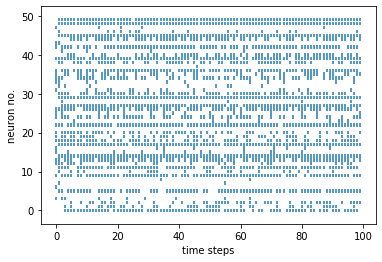

In [6]:
rasterplot(S_mat[:50,:100])

## dynamics with plasticity

In [76]:
# Dynamics

S_mat = np.zeros((Neurons.N, Neurons.T))
Neurons.J = create_gaussian_J(Neurons.N, g=4)
J_0 = Neurons.J.copy()

for ind in tqdm(range(Neurons.T)):
    
    S_mat[:, ind] = Neurons.S
    
    if ind==int(Neurons.T/2):
        J_1 = Neurons.J.copy()
    
    update_Neurons(Neurons, update_input=False, update_connectivity=True)
    
J_2 = Neurons.J.copy()

<IPython.core.display.Javascript object>


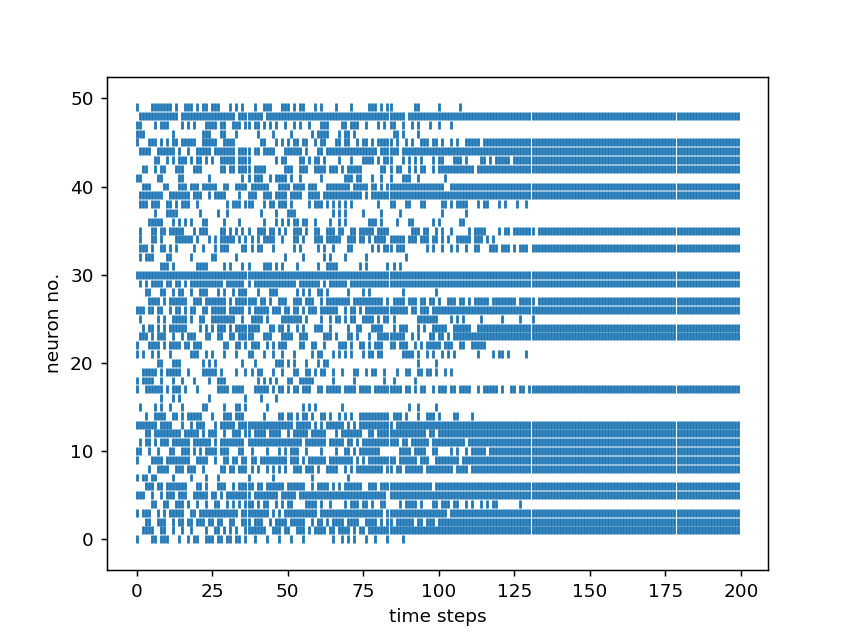

In [77]:
rasterplot(S_mat[:50,:200])

<IPython.core.display.Javascript object>


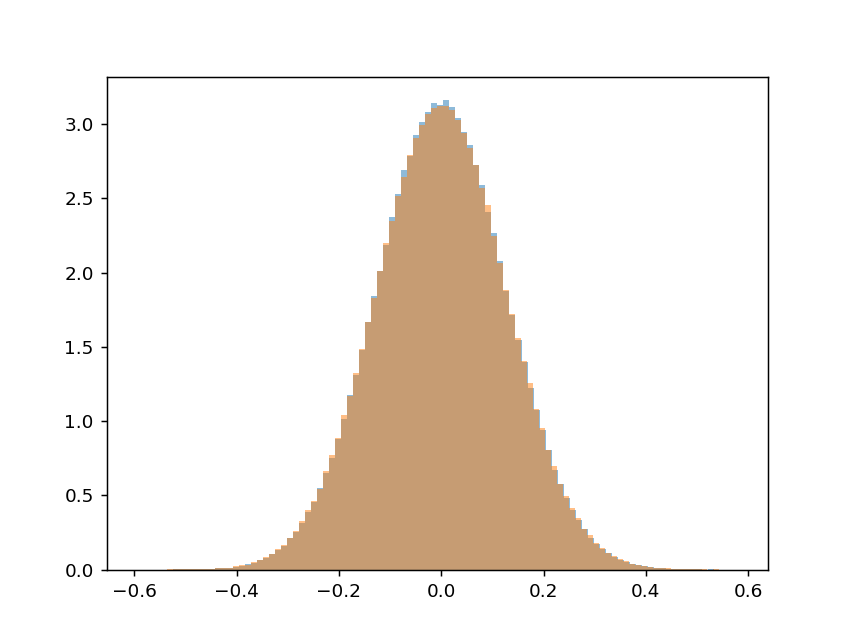

<IPython.core.display.Javascript object>


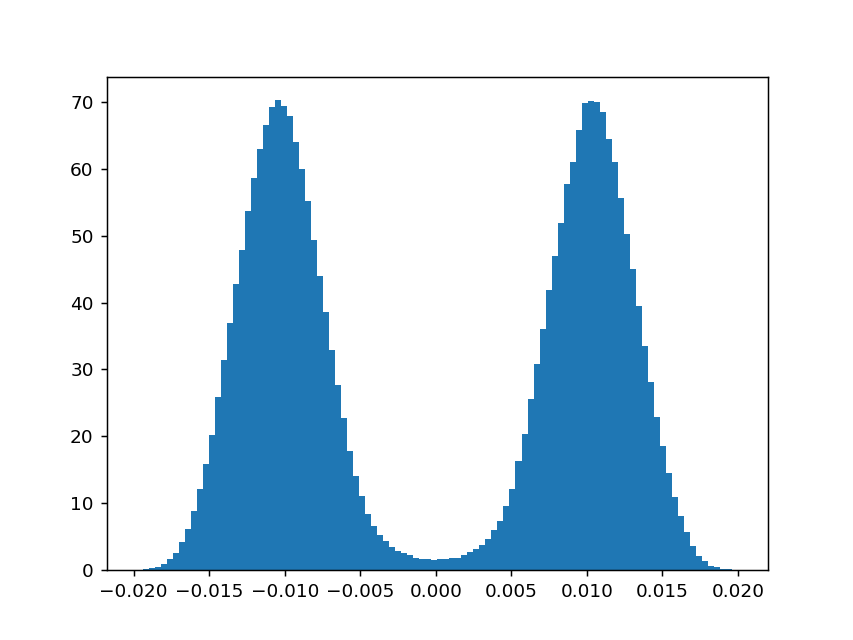

In [86]:
plt.figure()
plt.hist(J_0.flatten(), 100, density=True, alpha=0.5);
#plt.hist(J_1.flatten(), 40, density=True, alpha=0.5);
plt.hist(J_2.flatten(), 100, density=True, alpha=0.5);

plt.figure()
plt.hist((J_2-J_0).flatten(), 100, density=True);

## connectivity strength effect

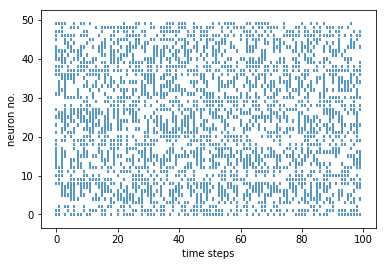

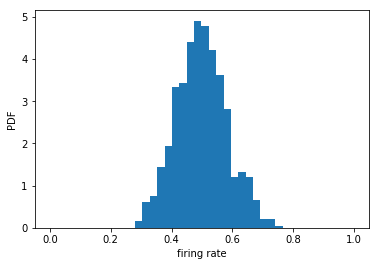

In [7]:
# sample connectivity

Neurons.J = create_gaussian_J(Neurons.N, g=10)
S_mat = np.zeros((Neurons.N, Neurons.T))

for ind in tqdm(range(Neurons.T)):
    
    S_mat[:, ind] = Neurons.S
    
    update_Neurons(Neurons, update_input=False, update_connectivity=False)
    
rasterplot(S_mat[:50,:100])
histplot(S_mat)

In [56]:
g_list = np.linspace(0,5,100)
m_mat = np.zeros((len(g_list), 4))
ent = np.zeros(len(g_list))

for ind1,g in tqdm(enumerate(g_list)):
    
    Neurons.J = create_gaussian_J(Neurons.N, g=g)
    S_mat = np.zeros((Neurons.N, Neurons.T))

    for ind2 in range(Neurons.T):
    
        S_mat[:, ind2] = Neurons.S
        update_Neurons(Neurons, update_input=False, update_connectivity=False)
        
    m_mat[ind1, :] = moments(S_mat)
    ent[ind1] = entropy(S_mat)
    

<IPython.core.display.Javascript object>


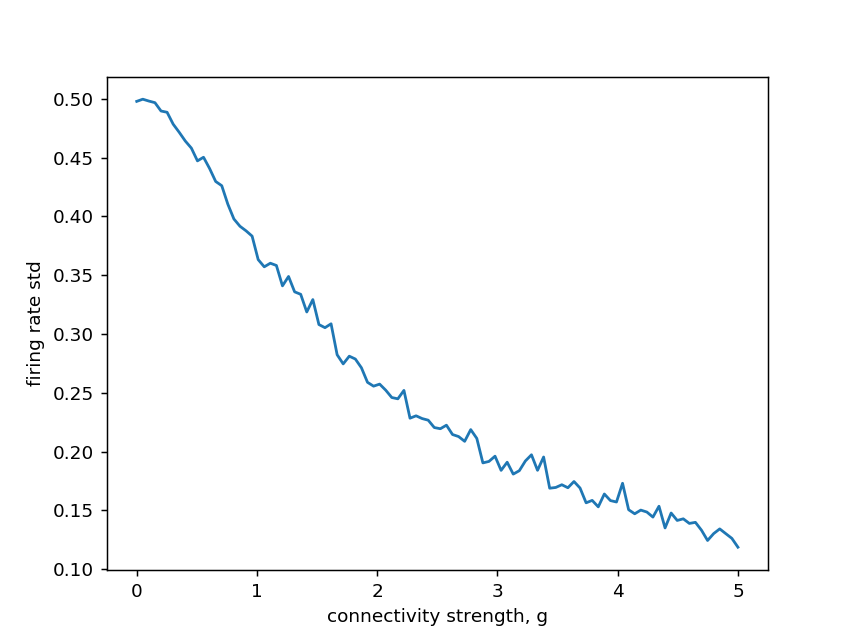

<IPython.core.display.Javascript object>


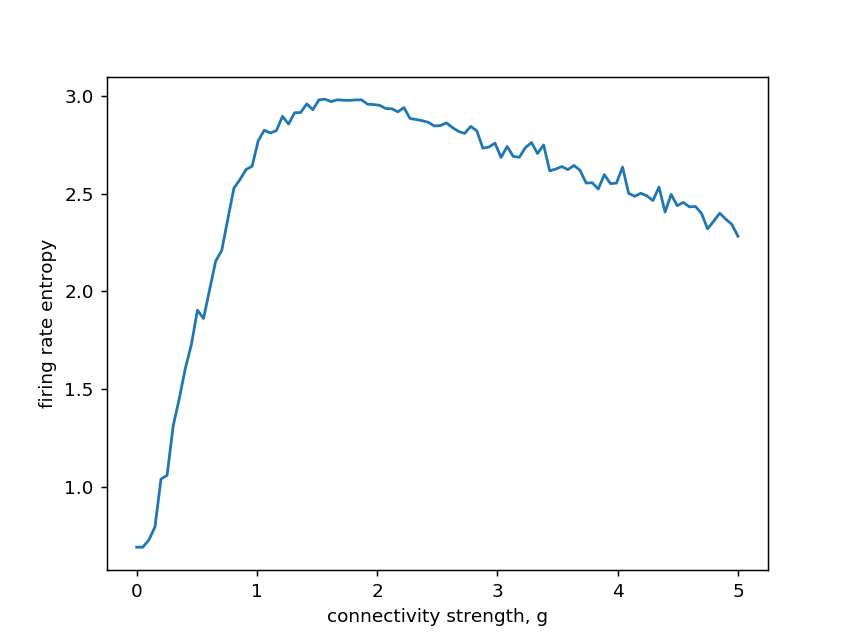

Text(0, 0.5, 'firing rate entropy')

In [57]:
plt.figure()
plt.plot(g_list, m_mat[:,1])
plt.xlabel('connectivity strength, g')
plt.ylabel('firing rate std')

plt.figure()
plt.plot(g_list, ent)
plt.xlabel('connectivity strength, g')
plt.ylabel('firing rate entropy')
